## Reading scRNA-seq data into Python

v1.0 (2021-03-26)  
Lucas Graybuck  

### Purpose

In this notebook, we'll see how the scRNA-seq .h5 files downlaoded from HISE can be read into Python for use with packages like `scanpy` and `scvi-tools`.

This notebook was generated using the `Python` language, running in the Jupyter Notebook environment on a HISE IDE instance. See the end of the document for the [Session Info](#Session-Info) for additional software version details.


### Before you start

You may need to install the relevant Python packages prior to running this notebook. To do so, open a terminal and run the following:

```
pip install llvmlite --ignore-installed
pip install numba==0.51.2
pip install leidenalg
pip install scanpy
pip install sinfo
```

<a name = "contents"></a>

### Contents

- [Importing packages](#Importing-packages)
- [Reading h5 files](#Reading-h5-files)
    - [Gene x cell matrix](#Gene-x-cell-matrix)
    - [Observation metadata](#Observation-metadata)
- [Assembling AnnData](#Assembling-AnnData)
- [Combining multiple files](#Combining-multiple-files)
- [Saving and loading AnnData](#Saving-and-loading-AnnData)
- [Basic analysis with scanpy](#Basic-analysis-with-scanpy)
- [Session Info](#Session-Info)

### Importing packages

To read files and construct AnnData objects, we'll need to import the following Python packages:

- `h5py`: Provides a read/write API for .h5 files
- `scipy.sparse`: Provides functions and classes for working with sparse matrices
- `pandas`: A data frame package for Python
- `anndata`: Allows construction of AnnData objects that can be used with downstream tools
- `scanpy`: One such downstream tool, which we'll use to demonstrate the use of AnnData objects.
- `os`: Used for file handling

In [1]:
import h5py
import scipy.sparse as scs
import pandas
import anndata
import scanpy
import os

### Reading h5 files

To demonstrate reading .h5 files, we'll use `h5py` to read in data that we downloaded in the previous notebook (`01-R Retrieving data from HISE.ipynb`)

More info on `h5py` is available in [the h5py documentation](https://docs.h5py.org/en/stable/index.html).

First, we'll connect to one of the .h5 files:

In [2]:
h5_file = 'cache/2716b9e4-38f3-4225-bfbe-1fef010e1926/B017-P1_PB00135-01_2020-09-15T19:35:44.423205814Z_labeled.h5'
h5_con = h5py.File(h5_file, mode = 'r')

To see what's in the file, we can use the `.keys()` method, along with square-bracket accessors:

In [3]:
h5_con.keys()

<KeysViewHDF5 ['hash', 'matrix', 'pca', 'well']>

Most of what we're after here is in the 'matrix':

In [4]:
h5_con['matrix'].keys()

<KeysViewHDF5 ['barcodes', 'data', 'features', 'indices', 'indptr', 'observations', 'shape']>

Just square brackets provides a "view" into the .h5, but doesn't actually read data into memory (helpful for reducing memory overhead). 

To read, we'll use `[:]`:

In [5]:
h5_shape = h5_con['matrix']['shape'][:]
h5_shape

array([33538, 18002], dtype=uint16)

#### Gene x cell matrix

First, we'll read in the Gene x Cell count matrix as a SciPy sparse matrix (see docs for further details: [csc_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html))

In [6]:
def read_mat(h5_con):
    mat = scs.csc_matrix(
        (h5_con['matrix']['data'][:], # Count values
         h5_con['matrix']['indices'][:], # Row indices
         h5_con['matrix']['indptr'][:]), # Pointers for column positions
        shape = tuple(h5_con['matrix']['shape'][:]) # Matrix dimensions
    )
    return mat

mat = read_mat(h5_con)

We'll also grab the gene symbols from the .h5:

In [7]:
genes = h5_con['matrix']['features']['name'][:]
genes = [x.decode('UTF-8') for x in genes]

#### Observation metadata

In AnnData, each single cell is referred to as an 'observation'.

Observation metadata is stored in the .h5 files in 'matrix/observations/'. We'll need to build a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) from this metadata for use with AnnData.

Because of how the string/character values are stored in the .h5 files, we'll need to check for and decode these for later use:

In [8]:
def read_obs(h5con):
    bc = h5con['matrix']['barcodes'][:]
    bc = [x.decode('UTF-8') for x in bc]

    # Initialized the DataFrame with cell barcodes
    obs_df = pandas.DataFrame({ 'barcodes' : bc })

    # Get the list of available metadata columns
    obs_columns = h5con['matrix']['observations'].keys()

    # For each column
    for col in obs_columns:
        # Read the values
        values = h5con['matrix']['observations'][col][:]
        # Check for byte storage
        if(isinstance(values[0], (bytes, bytearray))):
            # Decode byte strings
            values = [x.decode('UTF-8') for x in values]
        # Add column to the DataFrame
        obs_df[col] = values
    
    return obs_df

obs_df = read_obs(h5_con)
obs_df.head()

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,n_umis,original_barcodes,pbmc_sample_id,pool_id,seurat_pbmc_type,seurat_pbmc_type_score,umap_1,umap_2,well_id
0,754659defa4d11ea81509e49704367d9,B017,genial_bottom_borer,754659defa4d11ea81509e49704367d9,B017-P1C1,AGTAAGTTCAGCGTA,singlet,1972,73,15861,4753,AAACCCATCCGAACGC,PB00135-01,B017-P1,NK cell,1.000000,3.708320,-9.641528,B017-P1C1W1
1,7546614afa4d11ea81509e49704367d9,B017,sheepish_proscience_kinkajou,7546614afa4d11ea81509e49704367d9,B017-P1C1,AGTAAGTTCAGCGTA,singlet,1217,33,10499,3138,AAACGAAGTGCATTTG,PB00135-01,B017-P1,CD8 Naive,1.000000,1.390753,6.279734,B017-P1C1W1
2,75466474fa4d11ea81509e49704367d9,B017,refreshful_undiseased_urus,75466474fa4d11ea81509e49704367d9,B017-P1C1,AGTAAGTTCAGCGTA,singlet,1419,30,13283,3914,AAACGCTAGACGATAT,PB00135-01,B017-P1,CD4 Memory,0.536157,2.776639,8.790216,B017-P1C1W1
3,75466f28fa4d11ea81509e49704367d9,B017,teal_goodish_meadowlark,75466f28fa4d11ea81509e49704367d9,B017-P1C1,AGTAAGTTCAGCGTA,singlet,466,89,2707,904,AAACGCTGTGATGGCA,PB00135-01,B017-P1,CD8 effector,0.484048,-1.005538,0.144422,B017-P1C1W1
4,7546845efa4d11ea81509e49704367d9,B017,hazy_blameless_narwhale,7546845efa4d11ea81509e49704367d9,B017-P1C1,AGTAAGTTCAGCGTA,singlet,1315,66,9897,2985,AAAGGATGTAAGTTAG,PB00135-01,B017-P1,NK cell,1.000000,4.386500,-8.025678,B017-P1C1W1


### Assembling AnnData

Now that we have the matrix and metadata, we can assemble the AnnData object.

Note that the matrix will need to be transposed with the `.T` method, because AnnData stores matrices in the opposite orientation of the .h5 files.

In [9]:
adata = anndata.AnnData(mat.T,
                        obs = obs_df)

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


We can then add the genes as variable names to the AnnData

In [10]:
adata.var_names = genes

Finally, we'll need to make sure the variable names (gene names) are unique.

In [11]:
adata.var_names_make_unique()

#### Combining multiple files

To combine multiple files for analysis together, we can read in additional .h5 files, and add them on to the existing AnnData with the `.concatenate()` method

In [12]:
h5_file2 = 'cache/58687b56-b0d6-4d0b-a46e-da57f7cf4665/B017-P1_PB00134-01_2020-09-15T19:35:44.423205814Z_labeled.h5'
h5_con2 = h5py.File(h5_file2, mode = 'r')

mat2 = read_mat(h5_con2)
obs_df2 = read_obs(h5_con2)

adata2 = anndata.AnnData(mat2.T,
                         obs = obs_df2)

adata2.var_names = genes

adata2.var_names_make_unique()

Cells in first adata:

In [13]:
adata.shape[0]

18002

Cells in second adata:

In [14]:
adata2.shape[0]

16663

Combine the two datasets

In [15]:
joint_adata = adata.concatenate(adata2)

Cells in joint adata:

In [16]:
joint_adata.shape[0]

34665

### Saving and loading AnnData

Saving and loading AnnData files is straightforward using the `.write_h5ad()` method and the `anndata.read_h5ad()` or `scanpy.read_h5ad()` function.

In [17]:
os.mkdir('adata_files')

In [18]:
joint_adata.write_h5ad('adata_files/joint_data.h5ad')

... storing 'batch_id' as categorical
... storing 'chip_id' as categorical
... storing 'hto_barcode' as categorical
... storing 'hto_category' as categorical
... storing 'original_barcodes' as categorical
... storing 'pbmc_sample_id' as categorical
... storing 'pool_id' as categorical
... storing 'seurat_pbmc_type' as categorical
... storing 'well_id' as categorical


In [19]:
joint_adata = anndata.read_h5ad('adata_files/joint_data.h5ad')
# Does the same thing - for times when you don't want to load both anndata and scanpy
joint_adata = scanpy.read_h5ad('adata_files/joint_data.h5ad')

### Basic analysis with scanpy

The `scanpy` package provides a suite of tools for analysis of scRNA-seq data in Python.

See the [`scanpy` documentation](https://scanpy.readthedocs.io/en/stable/) for additional details.

Here, we'll demonstrate some basic normalization, feature selection, dimensionality reduction, and plotting

In [20]:
%%time

# Normalize data by read count per cell
scanpy.pp.normalize_total(joint_adata, target_sum=1e4)

# Log transform the normalized data
scanpy.pp.log1p(joint_adata)

# Find highly variable genes
scanpy.pp.highly_variable_genes(joint_adata)

CPU times: user 6.86 s, sys: 131 ms, total: 6.99 s
Wall time: 6.98 s


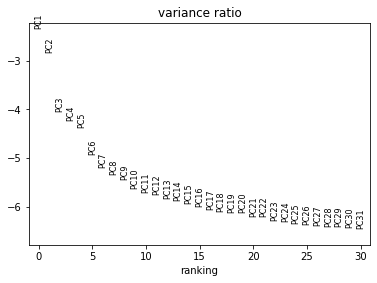

CPU times: user 46 s, sys: 2.22 s, total: 48.3 s
Wall time: 12.7 s


In [21]:
%%time

# Run PCA
scanpy.tl.pca(joint_adata)

# Examine variance ratios of PCs
scanpy.pl.pca_variance_ratio(joint_adata, log=True)

In [22]:
%%time

# Find nearest-neighbors for use with UMAP and clustering
scanpy.pp.neighbors(joint_adata, n_pcs = 30)

CPU times: user 53.3 s, sys: 1.9 s, total: 55.2 s
Wall time: 49.8 s


In [28]:
%%time

# Run leiden clustering
scanpy.tl.leiden(joint_adata)

CPU times: user 7.74 s, sys: 120 ms, total: 7.86 s
Wall time: 7.85 s


In [30]:
%%time

# Run UMAP
scanpy.tl.umap(joint_adata)

CPU times: user 34.3 s, sys: 238 ms, total: 34.5 s
Wall time: 27.7 s


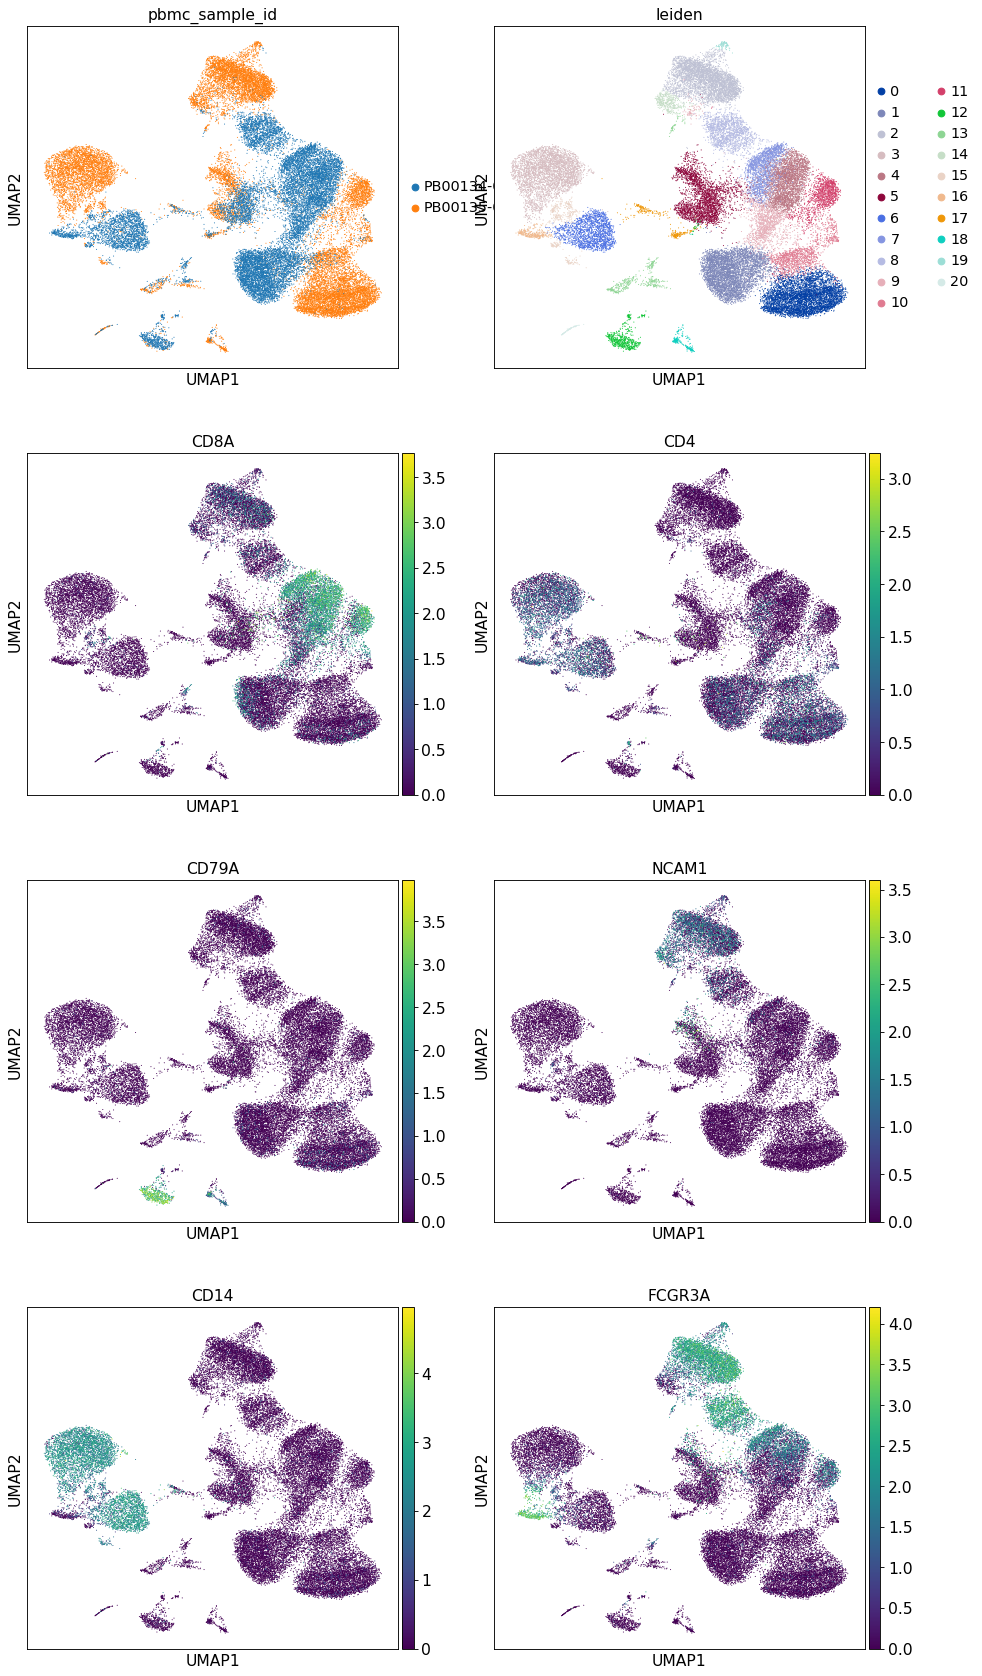

In [40]:
# View UMAP Plots
scanpy.set_figure_params(figsize = (6,6))

scanpy.pl.umap(joint_adata, 
               color = ['pbmc_sample_id','leiden',
                        'CD8A','CD4',
                        'CD79A','NCAM1',
                        'CD14','FCGR3A'],
               ncols = 2)

### Session Info

In [5]:
import sinfo
sinfo.sinfo(write_req_file = False)

-----
anndata     0.7.5
h5py        2.10.0
scanpy      1.7.1
scipy       1.4.1
sinfo       0.3.1
-----
IPython             7.13.0
jupyter_client      6.1.3
jupyter_core        4.6.3
jupyterlab          1.2.10
notebook            6.0.3
-----
Python 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) [GCC 7.3.0]
Linux-4.19.0-12-cloud-amd64-x86_64-with-debian-bullseye-sid
4 logical CPU cores, x86_64
-----
Session information updated at 2021-03-26 17:54
